In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

# Environment

#### Noisy Cart Pole

This is the noisy version of the CartPole-v0 environment of OpenAI.  
https://gym.openai.com/envs/CartPole-v0  
https://github.com/openai/gym/wiki/CartPole-v0  

In [2]:
class Environment:
    
    def __init__(self, stateDimension, actionDimension, actionSpace, reset, step):
        self.stateDimension = stateDimension
        self.actionDimension = actionDimension
        self.actionSpace = actionSpace
        self.reset = reset
        self.step = step

In [3]:
class NoisyCartPole:

    stateDimension = 4
    actionDimension = 1
    transitionSigmas = [ 0.01, 0, 0.01, 0 ]
    alreadyFinished = False
    
    def __init__(self):
        self.openAI = gym.make('CartPole-v0')
        
    def reset(self):
        self.alreadyFinished = False
        return self.openAI.reset()

    def step(self, state, action):
        
        if self.alreadyFinished:
            # Zero reward till the end of the episode if pole is already dropped
            return state, 0, True, None
        
        else:
            # OpenAI Step
            next_state, reward, self.alreadyFinished, info = self.openAI.step(int(action))
            # Adding Noise 
            next_state += np.random.randn(self.stateDimension) * self.transitionSigmas
            
            return next_state, reward, self.alreadyFinished, info


### System Dynamics

In [4]:
def cartpole_reset():
    state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
    return np.array(state)

In [5]:
# Extracted from OpenAI environment CartPole-v0
def cartpole_step(state, action):
    
    gravity = 9.8
    masscart = 1.0
    masspole = 0.1
    total_mass = (masspole + masscart)
    length = 0.5 # actually half the pole's length
    polemass_length = (masspole * length)
    force_mag = 10.0
    tau = 0.02  # seconds between state updates

    # Angle at which to fail the episode
    theta_threshold_radians = 12 * 2 * math.pi / 360
    x_threshold = 2.4
    
    x, x_dot, theta, theta_dot = state
    
    already_done =  x < -x_threshold \
        or x > x_threshold \
        or theta < -theta_threshold_radians \
        or theta > theta_threshold_radians
    already_done = bool(already_done)
    
    if already_done:
        
        next_state = state
        reward = 0
        done = True
        
    else:
        
        force = force_mag if action==1 else -force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + polemass_length * theta_dot * theta_dot * sintheta) / total_mass
        thetaacc = (gravity * sintheta - costheta* temp) / (length * (4.0/3.0 - masspole * costheta * costheta / total_mass))
        xacc  = temp - polemass_length * thetaacc * costheta / total_mass
        x  = x + tau * x_dot
        x_dot = x_dot + tau * xacc
        theta = theta + tau * theta_dot
        theta_dot = theta_dot + tau * thetaacc
        next_state = np.array([x,x_dot,theta,theta_dot])
        
        reward = 1
        
        done =  x < -x_threshold \
            or x > x_threshold \
            or theta < -theta_threshold_radians \
            or theta > theta_threshold_radians
        done = bool(done)
    
    return next_state, reward, done, {}

In [6]:
def noisycartpole_reset():
    return cartpole_reset()

In [7]:
def noisycartpole_step(state, action):
    
    transitionSigmas = [ 0.01, 0, 0.01, 0 ]
    
    next_state, reward, done, info = cartpole_step(state, action)   # CartPole Step
    
    if not done:
        next_state += np.random.randn(4) * transitionSigmas        # Adding Noise 

    return next_state, reward, done, info

In [8]:
env = Environment(4,1,range(2),noisycartpole_reset, noisycartpole_step)

# Policy

In [9]:
class SciKitPolicy():

    def __init__(self):
        raise NotImplementedError()

    def query(self, states):
        if len(states.shape) == 1:
            states = states.reshape(1, -1)
        return self.method.predict(states)

    def train(self, inputs, targets):
        self.method.fit(inputs, targets)

    def m_step(self, states, actions):

        # States/Actions -> Inputs/Targets
        inputs, targets = trajectory2tuples(states, actions)

        # Train kNN
        self.train(inputs, targets.ravel())

In [10]:
class KnnPolicyDiscrete(SciKitPolicy):
    def __init__(self, k, weights='distance'):
        self.method = KNeighborsClassifier(n_neighbors=k, weights=weights, n_jobs=1)

In [11]:
class UniformPolicyDiscrete():

    def __init__(self, choices):
        self.choices = choices

    def query(self, states):
        return np.random.choice(self.choices, size=states.shape[0])

# Utility Functions

In [12]:
def rollout_trajectories(env, policy, horizon, sample_count=1, init=None):

    # States and Actions
    states = np.zeros((sample_count, horizon, env.stateDimension))
    actions = np.zeros((sample_count, horizon, env.actionDimension))
    rewards = np.zeros((sample_count, horizon))
    
    # Sample Trajectories
    for t in range(horizon):

        # Initialization
        if t == 0:
            if init is None:
                states[:,t,:] = [ env.reset() for i in range(sample_count) ]
            else:
                states[:,t,:] = init
                
        # Transition and Reward
        else:
            for s in range(sample_count):
                states[s, t, :], rewards[s,t-1], _1, _2 = env.step(states[s, t-1, :], actions[s, t-1, :])
        
        actions[:,t,:] = policy.query(states[:, t, :]).reshape(sample_count, env.actionDimension)
        
    for s in range(sample_count):
        _, rewards[s, horizon-1], _1, _2 = env.step(states[s, horizon-1, :], actions[s, horizon-1, :])

    return states, actions, rewards

In [13]:
def plot_trajectories(states, color='red', n=0):

    [sample_count, _, _] = states.shape

    if n==0:
        samples_drawn = range(sample_count)
    else:
        samples_drawn = np.random.choice(sample_count, n)
        
    for s in samples_drawn:
        plt.plot(states[s, :, 0], states[s, :, 2], '-', color=color)
        plt.plot(states[s, :, 0], states[s, :, 2], 'o', color=color, markersize=2)
        plt.plot(states[s, -1, 0], states[s, -1, 2], 'o', color=color, markersize=5)

In [14]:
def plot_iteration(states, rewards, selected=None, n=0, iteration=None):
    
    plot_trajectories(states, color='red', n=n)
    if selected is not None:
        plot_trajectories(selected, color='green', n=n)
    
    plt.grid()
    plt.vlines(0, -0.25, 0.25, linestyle='dotted')
    # plt.vlines(2.4, -0.25, 0.25, linestyle='dotted')
    # plt.vlines(-2.4, -0.25, 0.25, linestyle='dotted')
    plt.hlines(0, -2.4, 2.4, linestyle='dotted')
    plt.hlines(0.21, -2.4, 2.4, linestyle='dotted')
    plt.hlines(-0.21, -2.4, 2.4, linestyle='dotted')
    
    label = ''
    if iteration is not None:
        label += 'Iteration ' + str(iteration+1) + ' - '
    label +=  'Average Reward : ' + str(np.sum(rewards) / states.shape[0])
    plt.xlabel(label)
    
    plt.show()

In [15]:
import time
from IPython import display

def plot_mcmc(states, rewards, i):
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    time.sleep(0.1)
    
    plot_iteration(states, rewards, iteration=i)
    

# Parameters

In [16]:
# Environment  
horizon = 100

# Inference
sample_count = 1000
running_average = 20

# Markov Chain Monte Carlo

In [17]:
def proposal_prior(states_previous, actions_previous, rewards_previous):
    return rollout_trajectories(env, UniformPolicyDiscrete(env.actionSpace), horizon)

In [18]:
def proposal_keepthenprior(states, actions, rewards):
    
    t = np.random.randint(states.shape[0]+1) -1
    
    if t < 0:
        states, actions, rewards = \
            rollout_trajectories(env, UniformPolicyDiscrete(env.actionSpace), horizon )
    else:
        states[t:,:], actions[t:,:], rewards[t:] = \
            rollout_trajectories(env, UniformPolicyDiscrete(env.actionSpace), horizon-t, init=states[t])
    
    return states, actions, rewards 

In [19]:
# States and Actions
states = np.zeros((sample_count, horizon, env.stateDimension))
actions = np.zeros((sample_count, horizon, env.actionDimension))
rewards = np.zeros((sample_count, horizon))

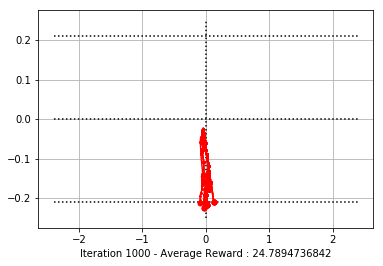

In [20]:
for i in range(sample_count):
    if i == 0:
        states[0,:,:], actions[0,:,:], rewards[0,:] = rollout_trajectories(env, UniformPolicyDiscrete(env.actionSpace), horizon)
    else:
        states_candidate, actions_candidate, rewards_candidate = \
            proposal_keepthenprior(states[i-1,:,:], actions[i-1,:,:], rewards[i-1,:])
            
        reward_previous = np.sum(rewards[i-1,:])    
        reward_candidate = np.sum(rewards_candidate)
        
        alpha = reward_candidate / reward_previous
        
        if np.random.rand() < alpha:
            states[i,:,:] = states_candidate
            actions[i,:,:] = actions_candidate
            rewards[i,:] = rewards_candidate
        else:
            states[i,:,:] = states[i-1,:,:]
            actions[i,:,:] = actions[i-1,:,:]
            rewards[i,:] = rewards[i-1,:]
    
    if i < running_average:
        plot_mcmc(states[0:i,:,:], rewards[0:i,:], i)
    else:
        plot_mcmc(states[i-running_average+1:i,:,:], rewards[i-running_average+1:i,:], i)

Text(0.5,0,'Running Average of Rewards')

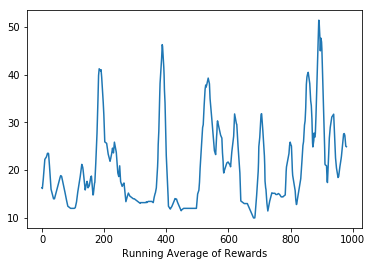

In [21]:
cumsum_rewards = np.cumsum(np.insert(np.sum(rewards,axis=1),0,0))
plt.plot((cumsum_rewards[running_average:] - cumsum_rewards[:-running_average]) / running_average )
plt.xlabel('Running Average of Rewards')